# ***Introduction***

This notebook demonstrates the implementation of multi object tracking integrated with Yolov11 model. It provide a simulation for building drone and bird classification, detection and tracking systems in real-world applications using real-time aerial video.

In [157]:
'''def colabSetup():
  from google.colab import drive
  drive.mount('/content/drive')

  #Install packages
  !pip install ultralytics
  !pip install deep_sort_realtime
  !pip install tensorflow_docs
  !apt-get install -y ffmpeg'''

"def colabSetup():\n  from google.colab import drive\n  drive.mount('/content/drive')\n\n  #Install packages\n  !pip install ultralytics\n  !pip install deep_sort_realtime\n  !pip install tensorflow_docs\n  !apt-get install -y ffmpeg"

In [158]:
#%%capture
'''colabSetup()'''

'colabSetup()'

In [159]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os


image 1/1 c:\Users\bplse\Seema\USD\AAI-521_ComputerVision\NICK_REPO_FinalProject\YOLO11_Model_best_checkpoint-20241204T214057Z-001\YOLO11_Model_best_checkpoint\0001.jpg: 288x640 6 drones, 198.9ms
Speed: 0.0ms preprocess, 198.9ms inference, 0.0ms postprocess per image at shape (1, 3, 288, 640)
Results saved to C:\Users\bplse\runs\detect\predict50


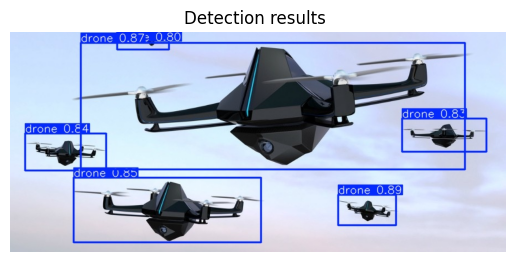

In [160]:
# Yolo model with best weight
model_path = 'yolo_best.pt'

def loadBestYoloModel(model_path):
  # Load trained yolo model
  model_yolo_best = YOLO(model_path)
  # Path to the test image
  test_image_path = "0001.jpg"

  # Predict
  results = model_yolo_best(test_image_path, save=True)[0]
  # Show prediction
  img = cv2.imread(results.save_dir + '/0001.jpg')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.title(f'Detection results ')
  plt.show()
  return model_yolo_best

model_yolo_best = loadBestYoloModel(model_path)

In [161]:
model_yolo_best.model_name

'yolo_best.pt'

# **Drone and Bird Tracking**

In [ ]:
import torch
from deep_sort_realtime.deepsort_tracker import DeepSort
#from google.colab.patches import cv2_imshow
from IPython.display import HTML
from base64 import b64encode
from IPython.display import display, clear_output
import io
import sys
import threading
import queue
import time
import torch
import pandas as pd


target_frame_sz = 640

test_video = 'drone1_flight.mp4' 
class_labels = ["drone", "bird"]

In [163]:
class DroneBirdYoloDetectionAndTracking:
    def __init__(self, input_video_file, output_video_file, yolo_model):
        self.yolo_model = yolo_model
        self.class_labels = ["drone", "bird"]
        self.target_frame_sz = 640
        self. test_video = input_video_file
        self.output_path = output_video_file
             
        # Initialize trackers
        self.deepsort_tracker  = DeepSort(max_age=200, n_init=10, nn_budget=100, max_cosine_distance=0.4)
        self.deepsort_tracker.iou_threshold = 0.01
       

    def get_num_frames(self):
        """Returns the total number of frames in a video."""
        cap = cv2.VideoCapture(self. test_video)
        if not cap.isOpened():
            raise ValueError(f"Cannot open video: {self. test_video}")
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        print(f"num_frames = {num_frames}, Width= {W}, Height={H}")
        cap.release()
        return num_frames
     
    def getDetectionsFromModelFrame(self, frame):
        """
        Get detections from YOLO model for a given frame.
        :param frame: Single video frame
        :param yolo_model: Preloaded YOLO model
        :return: List of detection tuples [(bbox, conf, cls)]
        """
        # Initialize an empty list to store detection tuples
        detection_tuples = []

        # Extract bounding boxes, confidences, and class IDs
        results_model = self.yolo_model(frame)[0]
        detections = results_model.boxes.xyxy.cpu().numpy()  
        confidences  = results_model.boxes.conf.cpu().numpy()  
        class_ids = results_model.boxes.cls.cpu().numpy()  # Class IDs (integers)
        labels = [self.class_labels[int(class_id)] for class_id in class_ids]

        print("class : " , labels, "detections :" , detections, "confidence : " , confidences)

        for box, conf, cls_id in zip(detections, confidences, class_ids):    
            x1, y1, x2, y2 = box
            detection_tuples.append(([x1, y1, x2-x1, y2-y1], float(conf), int(cls_id)))
        return  detection_tuples

    def getTracks(self, frame):
        """
        Get tracking information using DeepSort.
        :param frame: Single video frame
        :param tracker: Preloaded DeepSort tracker
        :param yolo_model: Preloaded YOLO model
        :return: List of tracked objects
        """
        detection_tuples = self.getDetectionsFromModelFrame(frame)
        tracked_objects = self.deepsort_tracker.update_tracks(detection_tuples, frame=frame)
        return tracked_objects, detection_tuples

    def search_space(self, test_video):
        """
        Loads a video, reads frames, and pushes them into the frame queue.
        :param test_video: Path to the video file
        """
        cap = cv2.VideoCapture(test_video)
        num_frames_remain = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Acquire frames....{num_frames_remain}")
        
        # Initialize queue for frames to hold unprocessed frames.
        self.frame_queue = queue.Queue(maxsize=num_frames_remain)
        
        while cap.isOpened() and num_frames_remain > 0 :     
            ret, vis_frame = cap.read()
            if not ret:
                self.frame_queue.put(None)  # Signal end of frames
                break    

            #print(f"Video Frame shape: {frame.shape}", file=sys.stderr, flush=True)
            # Resize the video frame for YOLO

            frame = cv2.resize(vis_frame, (self.target_frame_sz, self.target_frame_sz))

            # Push frames to frame_queue
            self.frame_queue.put(frame)
            num_frames_remain -=1
            #print(f" Put -> frame ", file=sys.stderr, flush=True)

        print("frame_queue size = ", self.frame_queue.qsize())
        cap.release()
        print("Completed search_space")

    def detect_and_track(self, output_path):
        """
        Process frames from the queue, perform detection and tracking, and save the results.
        :param output_path: Path to save the output video
        """
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = None
        i=0
        # Collect track data in a list
        track_data = []
                        
        while not self.frame_queue.empty():  
            i += 1
            if i %100 == 0:
                print("Frames to process:", self.frame_queue.qsize())
                    
            try:
                frame  = self.frame_queue.get()
            except self.frame_queue.Empty:
                print(f"queue is empty.")
                break
            
            # Terminate thread when the end signal is received
            if frame  is None:
                break

            #print(f"YOLO Queue Length: {frame_queue.qsize()}")
            if out is None:
                height, width, _ = frame.shape
                out = cv2.VideoWriter(output_path, fourcc, 30, (width, height))

            tracks, detections = self.getTracks(frame)
            if not tracks:
                print("No tracks found.")
            else:
                for track in tracks:
                    if track.is_confirmed():
                        bbox = track.to_tlbr()
                        track_id = track.track_id
                        
                        #track_conf = track.det_conf
                        track_conf = track.det_conf if track.det_conf is not None else 0.0
                        color_tracker = (0, int(255 * track_conf), 255 - int(255 * track_conf))  # Color based on confidence
                        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[0]) + int(bbox[2]), int(bbox[1]) + int(bbox[3])), color_tracker, 1)
                        cv2.putText(frame, f"Track Id: {track_id}", (int(bbox[0]) + 10, int(bbox[1]) - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)
                        
                        # Append track data
                        track_data.append({'class': track.det_class, 'trackid': track_id, 'confidence': track_conf, 'boundingbox': bbox})
                        
                    else:
                        print(f"Track Not confirmed.") 
                
            if not detections:
                print("No detections found.")
            else:  
                for detection in detections:                
                    temp = detection[0]
                    color = (0, int(255 * detection[1]), 255 - int(255 * detection[1]))  # Color based on confidence

                    cv2.rectangle(frame, (int(temp[0]), int(temp[1])), (int(temp[0]) + int(temp[2]), int(temp[1]) + int(temp[3])), color, 1)
                    cv2.putText(frame, f"{class_labels[detection[2]]}", (int(temp[0]), int(temp[1]) + 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

            # Write the frame in output video
            out.write(frame)
        self.track_dataframe = pd.DataFrame(track_data)
        out.release()

    def start_tracking(self):
        """
        Start the detection and tracking pipeline.
        :param test_video: Path to input video file
        :param output_path: Path to save the output video
        """
        # Load video and push frames into the queue        
        self.search_space(self.test_video)

        # Perform detection and tracking
        self.detect_and_track(self.output_path)
    
    def get_track_datas(self):
        """
        return track_dataframe
        """
        return self.track_dataframe
    


In [164]:
input_test_video = 'drone1_flight.mp4'
output_video = "output_video_drone1_flight.mp4"

# Create an instance of DroneBirdYoloDetectionAndTracking class
tracker = DroneBirdYoloDetectionAndTracking(input_test_video, output_video, model_yolo_best)


In [165]:
# Start traking process
tracker.start_tracking()

Acquire frames....1381
frame_queue size =  1381
Completed search_space

0: 640x640 1 drone, 356.1ms
Speed: 15.1ms preprocess, 356.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
class :  ['drone'] detections : [[     59.332      460.31      77.959      474.11]] confidence :  [    0.26897]
Track Not confirmed.

0: 640x640 (no detections), 297.5ms
Speed: 0.0ms preprocess, 297.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
class :  [] detections : [] confidence :  []
No tracks found.
No detections found.

0: 640x640 1 drone, 301.9ms
Speed: 0.0ms preprocess, 301.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
class :  ['drone'] detections : [[     60.089      461.25      76.259      472.45]] confidence :  [    0.27532]
Track Not confirmed.

0: 640x640 1 drone, 297.5ms
Speed: 0.0ms preprocess, 297.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
class :  ['drone'] detections : [[     58.903      461.31      

In [193]:
def plot_class_vs_confidence(df_track):
    plt.figure(figsize=(8, 6))
    for cls in df_track['class'].unique():
        subset = df_track[df_track['class'] == cls]
        plt.hist(
            subset['confidence'],
            bins=10,
            alpha=0.5,
            label=f"{class_labels[cls]} (n={len(subset)})"
        )

    plt.title("Class vs Confidence Distribution")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Trajectory (3D Scatter Plot)
def plot_trajectory(df_track):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    x = []
    y = []
    for i in range(len(df_track['boundingbox'])):
        x.append(df_track['boundingbox'][i][0])
        y.append(df_track['boundingbox'][i][1])
    
    ax.scatter(df_track.index, x, y, alpha=0.8, c=df_track['class'] ,
               marker='.',cmap='coolwarm', s=5)
    # Invert Y-axis (image coordinate system)
    ax.invert_zaxis()
    ax.set_title("Object Trajectories (in image coordinate wrt to index)")
    ax.set_xlabel("index")
    ax.set_ylabel("x")
    ax.set_zlabel("y")
    plt.show()

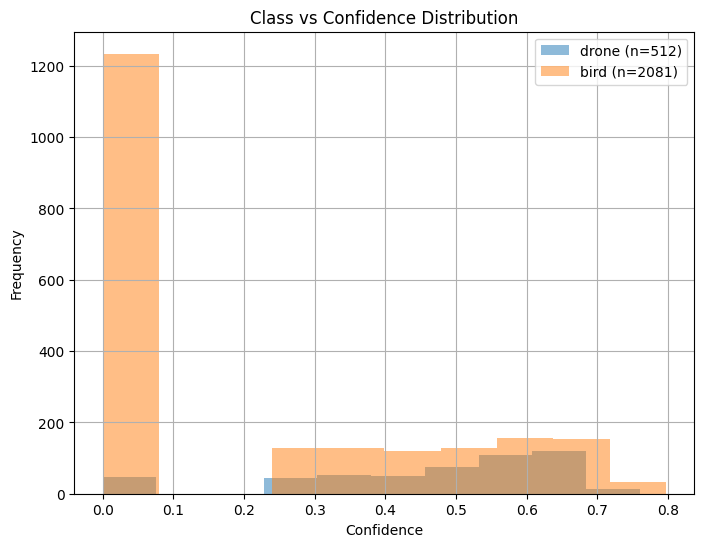

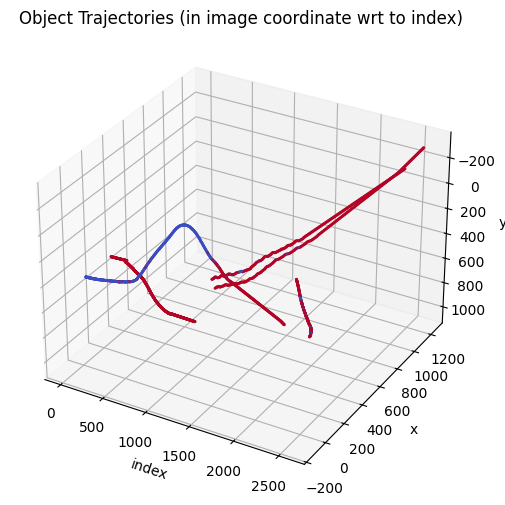

In [194]:
df_track = tracker.get_track_datas()
plot_class_vs_confidence(df_track)
plot_trajectory(df_track)